In [35]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18
from scipy import interpolate

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## DMParam

In [2]:
run_name = 'dhc_phph'

dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-22,
    struct_boost_model = 'erfc 1e-3',
)

## DarkHistory

In [4]:
! ls /n/holyscratch01/iaifi_lab/yitians/darkhistory/

DHdata_v1_1  DHdata_v1_1_230721  DHdata_v1_1_debug


In [3]:
os.environ['DH_DATA_DIR']

'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1'

In [ ]:
soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=4.+1, coarsen_factor=1, verbose=1,
    reion_switch=False,
    debug=True,
)

pickle.dump(soln, open(f"run_info/{run_name}_dh_soln.p", 'wb'))

In [14]:
run_name = 'dhc_phph'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
dh_xe_interp_func = lambda z: interpolate.interp1d(dh_soln['rs']-1, dh_soln['x'][:, 0])(z).item()

In [42]:
return_dict = evolve(
    run_name = 'dhc_phph_dhxe-d1',
    z_start = 45.,
    z_end = 43.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = '230629',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = ['uniform_xray'],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='run_info',
    debug_dhc_DH_xe_func=dh_xe_interp_func,
    debug_dhc_delta_one=True,
)
        

INFO:root:Using 21cmFAST version 0.1.dev1581+g40959ca
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_phph_dhxe-d1
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


get_init_cond 909.4750034943189 0.02353783025209757
residual_T_k -70.18912004083734
residual_x_e -0.0005694750809207318
1 input_heating 47.25154
2 input_heating -22.93757
before 979.6641 0.024107305
3 input_heating -22.93757
after 854.45013 0.02304275


## compare

In [9]:
def plot_global(dh_soln, soln):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    color_dict = {
        'DH' : 'k',
        '21' : 'r',
    }

    z_plot_start = 50.
    i_z_st = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_start))
    ax = axs[0,0]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['Tm'][i_z_st:]/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[0,1]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['x_e'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x_e$', title='$x_e$')
    ax.legend()

    ax = axs[0,2]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['1-x_H'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['1-x_H'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$1-x_H$', title='$1-x_H$')
    ax.legend()

    ax = axs[0,3]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

    ax = axs[1,0]
    dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_bath_engs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['E_phot'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['E_phot'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$E$ [eV/Bavg]', title='Bath energy')

    ax = axs[1,1]
    dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_heat'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{heat}$')

    ax = axs[1,2]
    dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_ion'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{ion}$')

    ax = axs[1,3]
    dh_fs = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_exc'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{exc}$')

In [23]:
s = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/dhc_phph_dhxe-d1/dh_init_soln.p", 'rb'))

In [27]:
np.interp(46, s['rs'][::-1], s['Tm'][::-1]) / phys.kB

909.475003494319

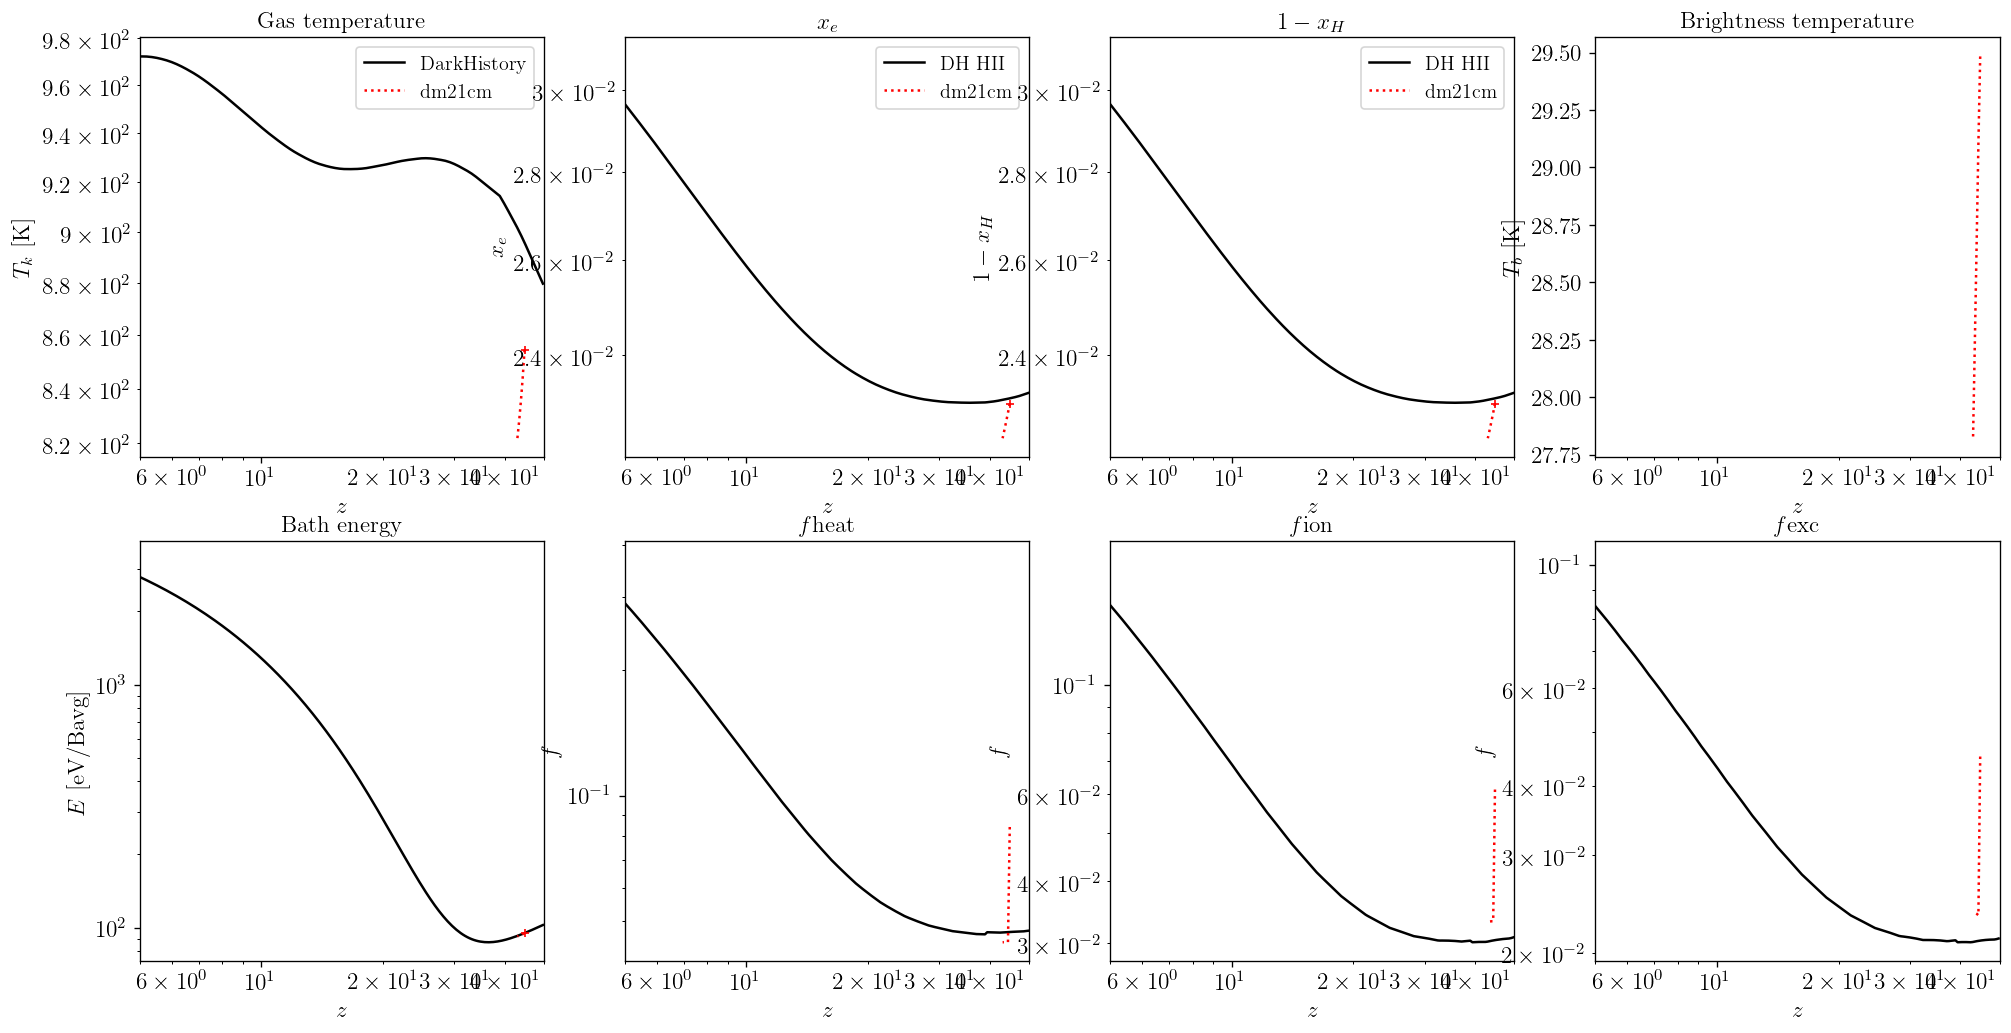

In [22]:
run_name = 'dhc_phph'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
run_name = 'dhc_phph_dhxe-d1'
soln = np.load(f"run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln)

In [43]:
dh_soln['f']['low'].keys()

dict_keys(['H ion', 'He ion', 'exc', 'heat', 'cont'])

In [68]:
zs = np.linspace(5.001, 44.999, 100)
dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_fs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['f_heat'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.1376472167124593

In [69]:
zs = np.linspace(5.001, 44.999, 100)
dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_bath_engs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['E_phot'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.05427165381579362

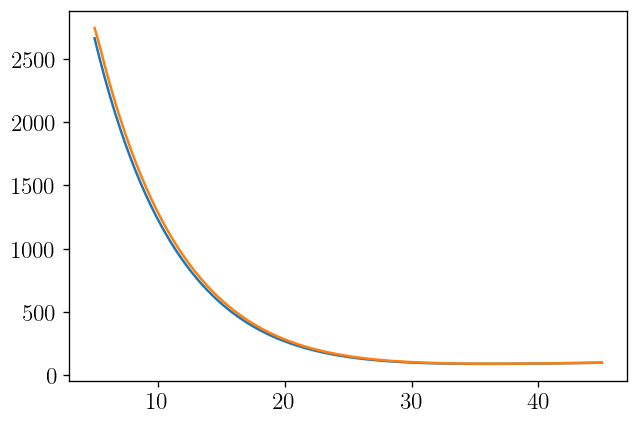

In [39]:
plt.plot(zs, p21c_arr)
plt.plot(zs, dh_arr)
